In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(0)

## Plotting

In [3]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [4]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [6]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [7]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=3))
    draw_outline(patch, 4)

In [8]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [9]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], id2cat[c], sz=16)

In [10]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

## Data Prep - Pascal

The most awful part

In [11]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/PASCAL_VOC'),
 PosixPath('data/pascal/pascal_val2012.json')]

In [12]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [13]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [14]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [15]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005867.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007772.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006240.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000207.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006243.jpg')]

In [16]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [17]:
i = 0
# get im filename
im_dict = trn_j[IMAGES][i]
im_dict[FILE_NAME],im_dict[ID]
# open image
im = open_image(IMG_PATH/im_dict[FILE_NAME])
# get annotations
im_anno = trn_anno[im_dict[ID]]

In [18]:
# im_anno: a single list which has tuple (bb, )
im_anno[0]

(array([ 96, 155, 269, 350]), 7)

In [19]:
im_anno

[(array([ 96, 155, 269, 350]), 7)]

In [20]:
# create multiclass classification csv
MC_CSV = PATH/'tmp/mc.csv'

mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [21]:
df.head()

,fn,clas
0,000012.jpg,car
1,000017.jpg,person horse
2,000023.jpg,bicycle person
3,000026.jpg,car
4,000032.jpg,aeroplane person


In [22]:
# create class and bbox csv s
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

### Dataset and Dataloader

In [23]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [24]:
f_model=resnet34
sz=256

In [25]:
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4, bs=16)

In [26]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [27]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [28]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [29]:
sample_x, sample_y_bb, sample_y_cls = x[0], y[0][0], y[1][0]

In [30]:
sample_y_bb, sample_y_cls

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 103.,
         53., 255., 193.,   0.,  56., 235., 206.,  10., 193., 248., 254.], dtype=float32),
 array([ 0,  0,  0,  0,  1, 14, 14]))

In [31]:
len(id2cat)

20

In [32]:
def show_gt(ax, x, y_bb, y_cls):
    """
    Show ground truth image and labels given a sample
    
    x, y_bb and y_cls : image, bbox array, cls idxs array
    
    Modified version of 'show_ground_truth'
    """
    # get non zero idxs for indexing labels
    nonzero_idxs = np.nonzero(y_cls)[0]

    # get cls indexes
    cls_idxs = y_cls[nonzero_idxs]

    # get bboxes - bb format
    bboxes = []
    for idx in nonzero_idxs:
        bboxes.append(y_bb[idx*4:(idx+1)*4])
    
    # show img, draw bboxes and text
    ax = show_img(x, ax=ax)
    for bb, cls_idx in zip(bboxes, cls_idxs):
        b = bb_hw(bb)
        draw_rect(ax, b, color=colr_list[cls_idx%len(colr_list)])
        draw_text(ax, b[:2], id2cat[cls_idx])

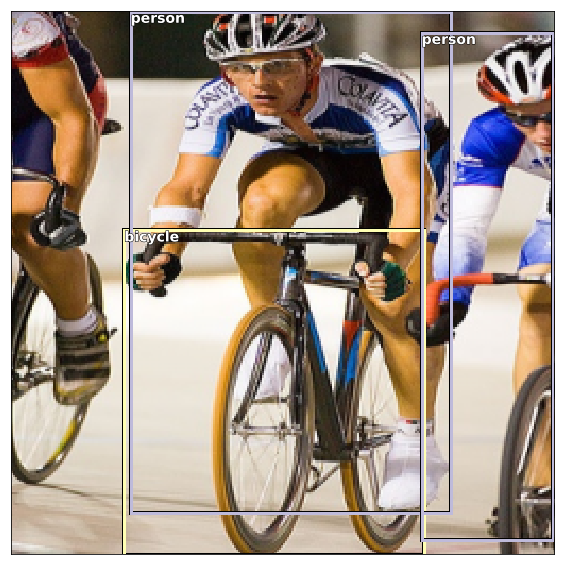

In [35]:
fig, ax = plt.subplots(figsize=(20, 10))
show_gt(ax, sample_x, sample_y_bb, sample_y_cls)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


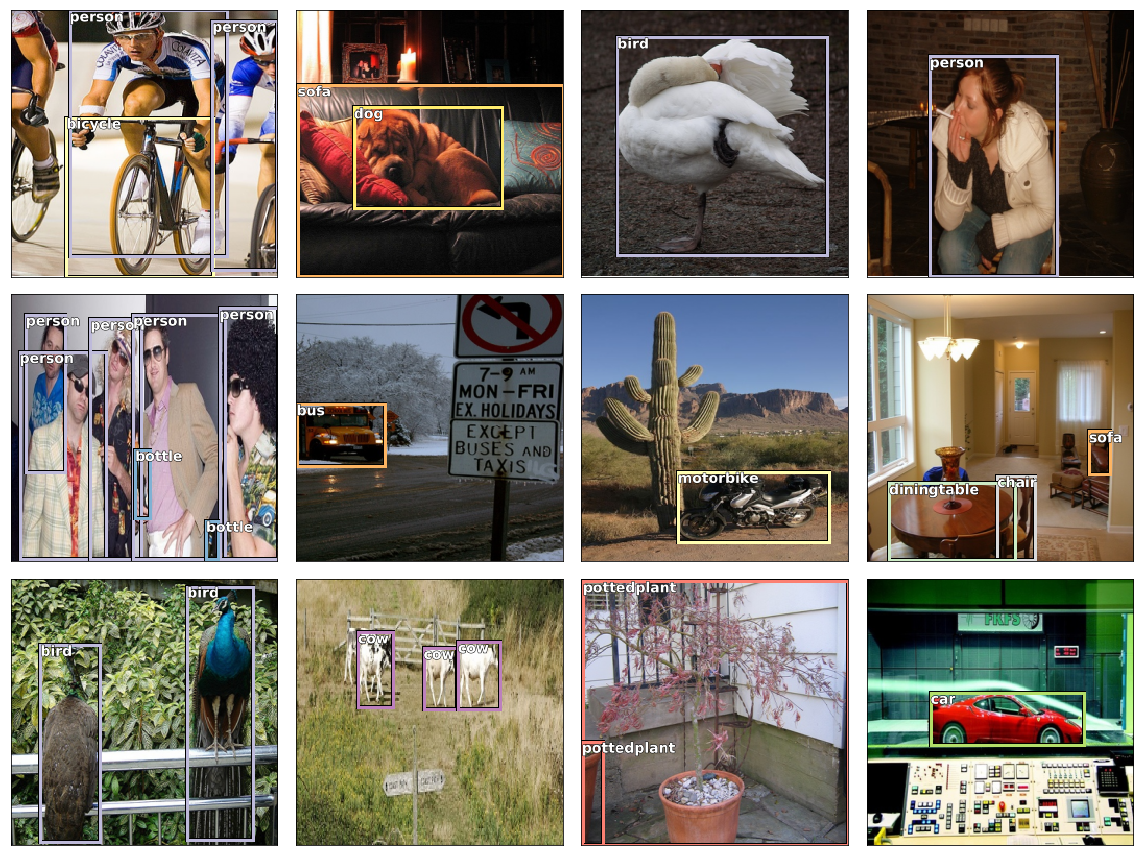

In [36]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_gt(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [141]:
# check data 
x, y = next(iter(md.trn_dl))

In [142]:
x.size(), y[0].size(), y[1].size()

(torch.Size([64, 3, 256, 256]), torch.Size([64, 40]), torch.Size([64, 10]))

## Model: RetinaNet

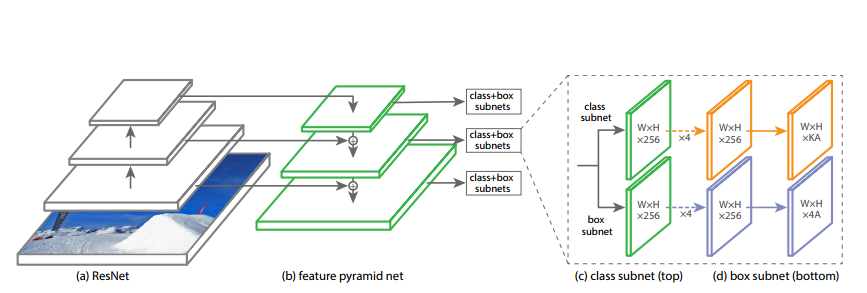

### Subnet1: Classification

"Taking an input feature map with C channels from a given pyramid level, the subnet applies four 3x3 conv layers, 
each with C filters and each followed by ReLU activations, followed by a 3x3 conv layer with KA filters. **Finally sigmoid activations are attached to output the KA
binary predictions per spatial location, see Figure 3 (c). We
use C = 256 and A = 9 in most experiments.**

We will use same notations from the paper 

**K:** number of classes

**A:** number of anchors

All new conv layers except the final one in the RetinaNet subnets are initialized with bias b = 0
and a Gaussian weight fill with $\sigma = 0.01$. For the final conv layer of the classification subnet, we set the bias initialization to $b = − log((1 − \pi)/\pi)$.

In [33]:
"""
K: number of classes
A: number of anchors - 9 for original paper
C: number of channels coming from the pyramid levels
"""
K, A, C = len(id2cat), 1, 256

In [34]:
def conv_bn_relu(kernel_size=3,stride=1, pad=1,in_c=256, out_c=256, use_bn=True):
    """Conv batchnorm relu block"""
    block = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size, stride, pad),
        nn.ReLU())
    if use_bn: block.add_module('3', nn.BatchNorm2d(in_c))
    
    # N(0, 0.01) bias = 0 initialization
    block[0].weight.data.normal_(0, 0.01)
    block[0].bias.data.zero_()
    
    return block

In [35]:
def flatten_conv(x, A):
    """
    IMPORTANT: Receptive fields should match target
    A: number of anchors
    
    Flatten output as:
    grid row 0 col 0 anchor 0
    grid row 0 col 0 anchor 1
    ...
    grid row 0 col 1 anchor 0
    grid row 0 col 1 anchor 1
    ...
    grid row 0 col 2 anchor 0
    grid row 0 col 2 anchor 1
    ...
    grid row n col n anchor A
    grid row n col n anchor A-1
    """
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//A)

In [36]:
class Subnet1(nn.Module):
    """For classification: outputs K*A"""
    def __init__(self, K, A, in_c, use_bn=False, depth=4, pi=0.01):
        super().__init__()
        
        # Number of anchors
        self.A = A
        
        # 4 block of convolutions
        self.conv = nn.Sequential(*children(conv_bn_relu())*depth)
        
        # Final convolutio for prediction
        self.out_conv = nn.Conv2d(in_c, K*A, kernel_size=3, stride=1, padding=1)    
        
        # N(0, 0.01) bias = -np.log((1-pi)/pi) initialization 
        self.out_conv.weight.data.normal_(0, 0.01)
        self.out_conv.bias.data = self.out_conv.bias.data.zero_() - np.log((1-pi)/pi)
        
    def forward(self, x):
        return flatten_conv(self.out_conv(self.conv(x)), self.A)

In [246]:
subnet1 = Subnet1(K, A, 256)

In [247]:
subnet1

Subnet1(
  (conv): Sequential(
    (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (3): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (9): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (out_conv): Conv2d (256, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Subnet2: Box Regression

"The design of the box regression subnet is identical to the classification subnet except that it terminates in 4A linear outputs per spatial location."

In [37]:
class Subnet2(nn.Module):
    """For classification: outputs 4*A"""
    def __init__(self, A, in_c, use_bn=False, depth=4):
        super().__init__()
        
        # Number of anchors
        self.A = A
        
        # 4 block of convolutions
        self.conv = nn.Sequential(*children(conv_bn_relu())*depth)
        
        # Final convolutio for prediction
        self.out_conv = nn.Conv2d(in_c, 4*A, kernel_size=3, stride=1, padding=1)    
        
        # N(0, 0.01) bias = 0
        self.out_conv.weight.data.normal_(0, 0.01)
        self.out_conv.bias.data = self.out_conv.bias.data.zero_()

    def forward(self, x):
        return flatten_conv(self.out_conv(self.conv(x)), self.A)

In [38]:
subnet2 = Subnet2(A, C)

In [250]:
subnet2

Subnet2(
  (conv): Sequential(
    (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (3): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (9): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (out_conv): Conv2d (256, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Backbone (ResNet + FPN)

"We experiment with ResNet-50-FPN and ResNet-101-FPN backbones [20]. The base ResNet-50 and ResNet-101 models are pre-trained on ImageNet1k; we use the models released by [16]. New layers added for FPN are initialized as in [20]."

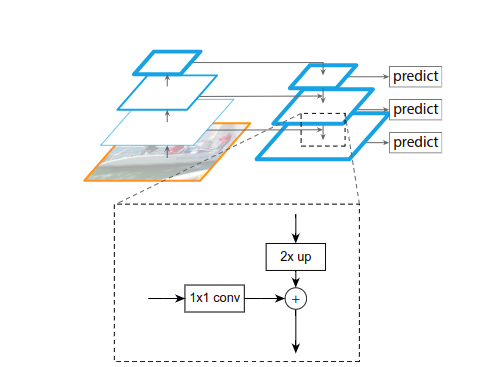

In [39]:
# load defined model
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

In [40]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [256]:
f_model=resnet50
sz=224
bs=64

cut, cut_lr = model_meta[f_model]
inp = V(torch.ones(1,3,sz,sz))
encoder = get_encoder(f_model, cut)

In [257]:
sfs = [SaveFeatures(encoder[i]) for i in range(len(children(encoder)))]

In [258]:
inp = V(torch.ones(1,3,sz,sz))

In [259]:
encoder(inp).size()

torch.Size([1, 2048, 7, 7])

**Paper Notes**

Following [20], we build FPN on top of the ResNet ar-
chitecture [16]. We construct a pyramid with levels P 3
through P 7 , where l indicates pyramid level (P l has reso-
lution 2 l lower than the input). As in [20] all pyramid levels
have C = 256 channels. Details of the pyramid generally
follow [20] with a few modest differences. 2 While many
design choices are not crucial, we emphasize the use of the
FPN backbone is; preliminary experiments using features
from only the final ResNet layer yielded low AP.

RetinaNet uses feature pyramid levels P3 to P7, where P3 to P5 are computed from the output of the corresponding ResNet residual stage (C3 through C5) using top-down and lateral connections just as in [FPN PAPER],

P6 is obtained via a 3x3 stride-2 conv on C5, and P7 is computed by apply-ing ReLU followed by a 3x3 stride-2 conv on P6. This differs slightly from [20]: (1) we don’t use the high-resolution pyramid level P2 for com-putational reasons, (2) P6 is computed by strided convolution instead of downsampling, and (3) we include P7 to improve large object detection. These minor modifications improve speed while maintaining accuracy. 4

In [260]:
# index C1, C2, C3, C4, C5 -> p2_out, p3_out, p4_out, p5_out, p6_out
[stage_act.features.size() for stage_act in sfs]

[torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 256, 56, 56]),
 torch.Size([1, 512, 28, 28]),
 torch.Size([1, 1024, 14, 14]),
 torch.Size([1, 2048, 7, 7])]

#### FPN

In [41]:
class FPN(nn.Module):
    def __init__(self, encoder, out_c=256):
        super().__init__()
        self.encoder = encoder        
        self.sfs = [SaveFeatures(encoder[i]) for i in range(len(children(encoder)))]
        self.out_c = out_c
                
    def forward(self, x):
        #pdb.set_trace()
        # encode image with ResNet backbone
        x = self.encoder(x)
        
        # get c1, c2, c3, c4, c5 activations
        c1 = self.sfs[2].features  #64 (sz/2)
        c2 = self.sfs[4].features  #256 (sz/4)
        c3 = self.sfs[5].features  #512 (sz/8)
        c4 = self.sfs[6].features  #1024 (sz/16)
        c5 = self.sfs[7].features  #2048 (sz/32) : sz should be divisible by 32
        
        C_sz = c5.size()[1] # 2048
        
        # construct convs
        if not hasattr(self, 'P6_conv1'):
            # get channel size of each intermediate activation
            self.sfs_c_sz = [stage_act.features.size()[1] for stage_act in self.sfs]
            
            self.P6_conv1 = nn.Conv2d(C_sz, self.out_c, kernel_size=3, stride=2, padding=1)
            self.P6_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P5_conv1 = nn.Conv2d(C_sz, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P5_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P4_conv1 = nn.Conv2d(C_sz//2, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P4_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P3_conv1 = nn.Conv2d(C_sz//4, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P3_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P2_conv1 = nn.Conv2d(C_sz//8, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P2_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)        
            
        # get P2, P3, P4, P5, P6
        p6 = self.P6_conv1(c5)
        p6_out = self.P6_conv2(p6)
        
        p5 = self.P5_conv1(c5) + F.upsample(p6, scale_factor=2, mode='nearest')
        p5_out = self.P5_conv2(p5)
        
        p4 = self.P4_conv1(c4) + F.upsample(p5, scale_factor=2, mode='nearest')
        p4_out = self.P4_conv2(p4)
        
        p3 = self.P3_conv1(c3) + F.upsample(p4, scale_factor=2, mode='nearest')
        p3_out = self.P3_conv2(p3)
        
        p2 = self.P2_conv1(c2) + F.upsample(p3, scale_factor=2, mode='nearest')
        p2_out = self.P2_conv2(p2)
    
        return [p2_out, p3_out, p4_out, p5_out, p6_out]

In [42]:
for l in range(2,7):
    print(f'Resolution of level P{l}:' ,(256 / 2**l))

Resolution of level P2: 64.0
Resolution of level P3: 32.0
Resolution of level P4: 16.0
Resolution of level P5: 8.0
Resolution of level P6: 4.0


In [288]:
f_model=resnet34
sz=256
bs=64

cut, cut_lr = model_meta[f_model]
inp = V(torch.ones(1,3,sz,sz))
encoder = get_encoder(f_model, cut)

In [289]:
out = encoder(inp)

In [290]:
fpn = FPN(encoder=encoder)

In [292]:
outs = fpn(inp)

In [293]:
#[p2_out, p3_out, p4_out, p5_out, p6_out]

[out.size() for out in outs]

[torch.Size([1, 256, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 16, 16]),
 torch.Size([1, 256, 8, 8]),
 torch.Size([1, 256, 4, 4])]

### RetinaNet

In [43]:
class RetinaNet(nn.Module):
    def __init__(self, fpn, subnet1, subnet2):
        super().__init__()
        self.fpn = fpn # initialize FPN
        self.subnet1 = subnet1 # initialize classifier
        self.subnet2 = subnet2 # initialize regressor
    
    def forward(self, x):
        p2_out, p3_out, p4_out, p5_out, p6_out = self.fpn(x)
        
        cls_out1 = self.subnet1(p2_out) # 4x4 - > 16*A anchors - feature from P2
        cls_out2 = self.subnet1(p3_out) # 8x8 - > 64*A anchors - feature from P3
        cls_out3 = self.subnet1(p4_out) # 16x16 - > 256*A anchors - feature from P4
        cls_out4 = self.subnet1(p5_out) # 32x32 - > 32*32*A anchors - feature from P5
        cls_out5 = self.subnet1(p6_out) # 64x64 - > 64*64*A anchors - feature from P6
        
        reg_out1 = self.subnet2(p2_out) # 4x4 - > 16*A anchors - feature from P2
        reg_out2 = self.subnet2(p3_out) # 8x8 - > 64*A anchors - feature from P3
        reg_out3 = self.subnet2(p4_out) # 16x16 - > 256*A anchors - feature from P4
        reg_out4 = self.subnet2(p5_out) # 32x32 - > 32*32*A anchors - feature from P5
        reg_out5 = self.subnet2(p6_out) # 64x64 - > 64*64*A anchors - feature from P6
        
        
        # Concat outputs from different levels of the pyramid
        # Here, each output is coming from flatten_conv in this order:
        # grid row 0 col 0 anchor 0 level: 4x4
        # grid row 0 col 1 anchor 0 level: 4x4
        # ...
        # grid row 0 col 0 anchor 1 level: 4x4
        # grid row 0 col 1 anchor 1 level: 4x4
        #
        # grid row 0 col 0 anchor 0 level: 8x8
        # grid row 0 col 1 anchor 0 level: 8x8
        
        # grid row 0 col 0 anchor 0 level: 16x16
        # grid row 0 col 0 anchor 0 level: 16x16
        
        
        
        return [torch.cat([cls_out1, cls_out2, cls_out3, cls_out4, cls_out5], 1),
               torch.cat([reg_out1, reg_out2, reg_out3, reg_out4, reg_out5], 1)]

In [44]:
# 20 classes, 9 anchors per grid and 256 channels
K, A, in_c = len(id2cat), 1, 256

In [306]:
# initialize retinanet model
fpn, subnet1, subnet2 = FPN(encoder), Subnet1(K, A, in_c), Subnet2(A, in_c)
retina = RetinaNet(fpn, subnet1, subnet2)

In [307]:
out = retina(inp)

In [308]:
out[0].size(), out[1].size()

(torch.Size([1, 5456, 20]), torch.Size([1, 5456, 4]))

In [313]:
total_out = 0
for l in range(2,7):
    total_out += (256 / 2**l)**2

In [314]:
total_out

5456.0

### Creating Anchors for Model

We constructed the model to output from different levels of FPN. These feature maps will have sizes 4x4, 8x8 and 16x16 respectively. 

        # Concat outputs from different levels of the pyramid
        # Here, each output is coming from flatten_conv in this order:
        # grid row 0 col 0 anchor 0 level: 4x4
        # grid row 0 col 1 anchor 0 level: 4x4
        # ...
        # grid row 0 col 0 anchor 1 level: 4x4
        # grid row 0 col 1 anchor 1 level: 4x4
        #
        # grid row 0 col 0 anchor 0 level: 8x8
        # grid row 0 col 1 anchor 0 level: 8x8
        
        # grid row 0 col 0 anchor 0 level: 16x16
        # grid row 0 col 0 anchor 0 level: 16x16

In [45]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anc_grids = [4, 8, 16, 32, 64] 
             
#anc_zooms = [1, 2**(1/3), 2**(2/3)]
anc_zooms = [1]

#anc_ratios = [(1.,2.), (1.,1), (2.,1.)]
anc_ratios = [(1., 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios] # n_anc_zooms * n_anc_ratios

k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

1

In [46]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [47]:
anc_x

array([0.125  , 0.125  , 0.125  , ..., 0.99219, 0.99219, 0.99219])

In [48]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

#### Do sanity check to see if anchor order is correct

In [49]:
# anchor_cnr for 4x4
anchor_crn4 = anchor_cnr[:(4*4)]

# anchor_cnr for 8x8
anchor_crn8 = anchor_cnr[(4*4):(4*4 + 8*8)]

# anchor_cnr for 16x16
anchor_crn16 = anchor_cnr[(4*4 + 8*8): (4*4 + 8*8 + 16*16)]

# anchor_cnr for 32x32
anchor_crn32 = anchor_cnr[(4*4 + 8*8 + 16*16):(4*4 + 8*8 + 16*16 + 32*32)]

# anchor_cnr for 64x64
anchor_crn64 = anchor_cnr[(4*4 + 8*8 + 16*16 + 32*32): (4*4 + 8*8 + 16*16 + 32*32 + 64*64)]

In [50]:
# grid row 0 col 0 for 4x4
(to_np(anchor_crn4[0]))

array([0.  , 0.  , 0.25, 0.25], dtype=float32)

In [51]:
anchor_crn4

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.FloatTensor of size 16x4]

In [52]:
sz = 256

In [53]:
anchor_crn4[0]

Variable containing:
 0.0000
 0.0000
 0.2500
 0.2500
[torch.FloatTensor of size 4]

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(sample_x)

# grid row 0 col 1 for 4x4
for anc in (anchor_crn4):
    draw_rect(ax, to_np(anc)*256, color="red")
    
# grid row 0 col 1 for 8x8
for anc in (anchor_crn8):
    draw_rect(ax, to_np(anc)*256, color="red")

# grid row 0 col 1 for 16x16
for anc in (anchor_crn16):
    draw_rect(ax, to_np(anc)*256, color="red")

# grid row 0 col 1 for 32x32
for anc in (anchor_crn32):
    draw_rect(ax, to_np(anc)*256, color="red")

# grid row 0 col 1 for 64x64
for anc in (anchor_crn64):
    draw_rect(ax, to_np(anc)*256, color="red")


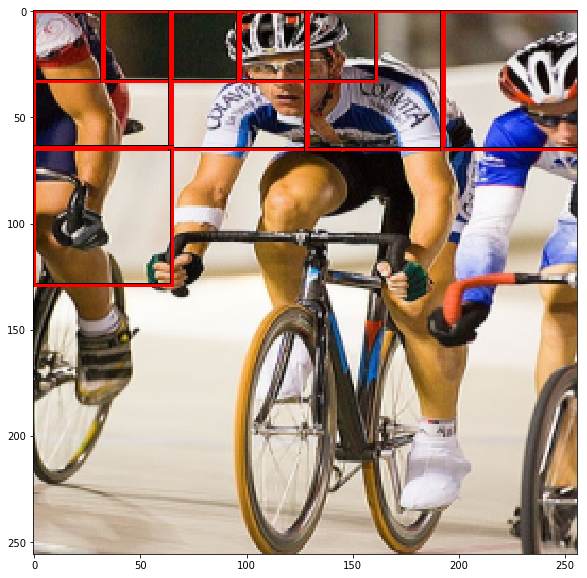

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(sample_x)

# grid row 0 col 1 for 4x4
for anc in anchor_crn4[:5]:
    draw_rect(ax, bb_hw(to_np(anc)*256), color="red")
    
for anc in anchor_crn8[:5]:
    draw_rect(ax, bb_hw(to_np(anc)*256), color="red")

### Now, we are certain that output from our model and anchors are in the same order.

### Loss and Model Definition

In [55]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [56]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [57]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    #bs = targ[0].size()[0]
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs # sum of bbox and class loss

In [142]:
# wrap for fastai 
class RetinaNetModel():
    def __init__(self, model, cut_lr, name='retinanet'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.fpn.encoder), [self.cut_lr]))
        return [lgs[0]] + [children(self.model.fpn)[1:]] + [children(self.model.subnet1)] + [children(self.model.subnet2)]

### Training

In [166]:
"""A: number of anchors, K: number of classes, in_c: number of channels for subnets"""

A, K, in_c = 1, 20, 256

In [167]:
f_model=resnet34
sz=256
bs=16

cut, cut_lr = model_meta[f_model]
inp = V(torch.ones(1,3,sz,sz))
encoder = get_encoder(f_model, cut)

In [168]:
# input channel for subnets, C = 256 in the paper
in_c = 256

# init FPN, Subnet1 and Subnet2
fpn, subnet1, subnet2 = FPN(encoder), Subnet1(K+1, A, in_c), Subnet2(A, in_c)

# init retina net
retina = RetinaNet(fpn, subnet1, subnet2)

# add get layer groups method
model = RetinaNetModel(retina, 8)

In [169]:
inp = V(torch.ones(1,3,256,256))

In [170]:
out = model.model(inp)

In [171]:
out

[Variable containing:
 ( 0  ,.,.) = 
  -5.0468 -4.6855 -3.9793  ...  -4.8118 -4.5678 -4.5900
  -4.6175 -4.6069 -4.4666  ...  -4.8001 -4.8134 -4.4870
  -4.5063 -4.8170 -4.4508  ...  -4.8395 -4.7647 -4.4935
            ...             ⋱             ...          
  -5.0493 -4.7264 -4.8343  ...  -4.7778 -4.9099 -4.9635
  -4.8253 -4.8677 -4.5890  ...  -4.3816 -4.6344 -4.3560
  -4.6811 -4.7058 -4.6285  ...  -4.6565 -4.5237 -4.6006
 [torch.FloatTensor of size 1x5456x21], Variable containing:
 ( 0  ,.,.) = 
   8.7393e-02  1.2437e-01 -1.5518e-02  1.4191e-01
  -6.2704e-01 -5.6736e-02 -1.3124e-01 -7.8715e-03
  -5.1519e-01 -1.5546e-01  1.5762e-01 -6.1606e-02
                        ⋮                        
  -1.8953e-01  1.7903e-01 -1.8393e-01 -1.9028e-01
  -3.3298e-01 -2.6378e-01 -1.3605e-01 -3.7552e-01
  -6.2513e-03  3.1936e-01  1.8532e-01  1.6279e-01
 [torch.FloatTensor of size 1x5456x4]]

In [172]:
# init learner and define optimizer 
learn = ConvLearner(md, model)
learn.crit = ssd_loss
learn.opt_fn = optim.Adam

In [176]:
x,y = next(iter(learn.data.trn_dl))

In [178]:
x.size(), len(y)

(torch.Size([16, 3, 256, 256]), 2)

In [185]:
sample_x = x[0][None, :]
sample_y_bb = y[0][0]
sample_y_clas = y[1][0]

In [198]:
pred = learn.model(V(sample_x))

In [201]:
pred[0], pred[1]

(Variable containing:
 ( 0  ,.,.) = 
  -4.5071 -4.6296 -4.5468  ...  -4.6607 -4.7282 -4.5480
  -4.6988 -4.5598 -4.5945  ...  -4.7664 -4.8246 -4.4411
  -4.7115 -4.5077 -4.7064  ...  -4.6383 -4.9122 -4.5281
            ...             ⋱             ...          
  -4.8465 -4.6617 -4.4346  ...  -4.7192 -4.8099 -4.8166
  -4.9963 -4.8948 -5.0060  ...  -4.7011 -4.5301 -4.3745
  -4.4490 -4.6363 -4.6613  ...  -4.4890 -4.2815 -4.6367
 [torch.FloatTensor of size 1x5456x21], Variable containing:
 ( 0  ,.,.) = 
  -7.5220e-02  2.6799e-01  8.8496e-02  6.0583e-02
  -1.6665e-01  3.3426e-01  6.4650e-02  1.0886e-01
  -2.3542e-01  1.2979e-01  2.2131e-01  1.1820e-01
                        ⋮                        
   1.3763e-01 -1.1861e-02 -2.7129e-01 -2.5396e-03
  -1.4854e-01 -1.4906e-01  1.1291e-01 -5.6117e-02
  -7.1979e-02  9.5135e-03  1.6995e-01  2.1726e-01
 [torch.FloatTensor of size 1x5456x4])

In [205]:
anchor_cnr = V(anchor_cnr)

In [214]:
list(zip(*pred, *[sample_y_bb, sample_y_clas]))[0]

(Variable containing:
 -4.5071 -4.6296 -4.5468  ...  -4.6607 -4.7282 -4.5480
 -4.6988 -4.5598 -4.5945  ...  -4.7664 -4.8246 -4.4411
 -4.7115 -4.5077 -4.7064  ...  -4.6383 -4.9122 -4.5281
           ...             ⋱             ...          
 -4.8465 -4.6617 -4.4346  ...  -4.7192 -4.8099 -4.8166
 -4.9963 -4.8948 -5.0060  ...  -4.7011 -4.5301 -4.3745
 -4.4490 -4.6363 -4.6613  ...  -4.4890 -4.2815 -4.6367
 [torch.FloatTensor of size 5456x21], Variable containing:
 -7.5220e-02  2.6799e-01  8.8496e-02  6.0583e-02
 -1.6665e-01  3.3426e-01  6.4650e-02  1.0886e-01
 -2.3542e-01  1.2979e-01  2.2131e-01  1.1820e-01
                        ⋮                        
  1.3763e-01 -1.1861e-02 -2.7129e-01 -2.5396e-03
 -1.4854e-01 -1.4906e-01  1.1291e-01 -5.6117e-02
 -7.1979e-02  9.5135e-03  1.6995e-01  2.1726e-01
 [torch.FloatTensor of size 5456x4], 88.0, 17)

In [150]:
learn.freeze_to(1)

In [151]:
??learn.freeze_to

In [152]:
layers = learn.models.get_layer_groups(False)

In [153]:
len(layers)

4

In [163]:
for l in layers[1]:
    for p in l.parameters():
        print(p.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [164]:
learn.lr_find(start_lr= 0.001)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/126 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([5456, 20])) must be the same as input size (torch.Size([5456, 19]))